In [1]:
# all imports should go here
import pandas as pd
import sys
import os
import subprocess
import datetime
import platform
import datetime
import math
import geopy.distance

import matplotlib.pyplot as plt
#import seaborn as sb

import cartopy
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.io.img_tiles import StamenTerrain
from cartopy.io.img_tiles import GoogleTiles
from owslib.wmts import WebMapTileService

from matplotlib.path import Path
import matplotlib.patheffects as PathEffects
from matplotlib import patheffects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np
from erddapy import ERDDAP
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [14]:
e = ERDDAP(server="https://gliders.ioos.us/erddap")
e.constraints = None
e.protocol = "tabledap"
e.dataset_id = "ce_320-20220720T1429"

opendap_url = e.get_download_url(
    response="opendap",
)

e.response = "nc"
#e.variables = ["longitude","depth","latitude","backscatter", "temperature", "salinity","time","dissolved_oxygen","chlorophyll"]

df_shallow = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
)


In [15]:
e = ERDDAP(server="https://gliders.ioos.us/erddap")
e.constraints = None
e.protocol = "tabledap"
e.dataset_id = "ce_383-20220720T1508"

opendap_url = e.get_download_url(
    response="opendap",
)

e.response = "nc"
#e.variables = ["longitude","depth","latitude","backscatter", "temperature", "salinity","time","dissolved_oxygen","chlorophyll"]

df_deep = e.to_pandas(
    index_col="time (UTC)",
    parse_dates=True,
)

In [16]:
start320 = '2022-08-03 20:05:54+00:00'
end320 = '2022-08-07 11:41:59+00:00'

df_shallow = df_shallow.loc[start320:end320,:]

In [17]:
start383 = '2022-08-06 00:00:00+00:00'
end383 = '2022-08-11 19:54:11+00:00'

df_deep = df_deep.loc[start383:end383,:]

In [18]:
df_shallow['distance']=df_shallow.apply(lambda row: geopy.distance.distance((47, -124.173),(row['latitude (degrees_north)'],row['longitude (degrees_east)'])).km, axis=1)
df_deep['distance']=df_deep.apply(lambda row: geopy.distance.distance((47, -124.173),(row['latitude (degrees_north)'],row['longitude (degrees_east)'])).km, axis=1)

In [7]:
df_shallow.columns

Index(['trajectory', 'wmo_id', 'profile_id', 'latitude (degrees_north)',
       'longitude (degrees_east)', 'depth (m)', 'backscatter (m-1)',
       'CDOM (ppb)', 'chlorophyll (ug l-1)', 'conductivity (S m-1)',
       'conductivity_qc', 'crs', 'ctd_timestamp (UTC)', 'density (kg m-3)',
       'density_qc', 'depth_qc', 'dissolved_oxygen (umol kg-1)',
       'instrument_ctd (1)', 'instrument_flbbcd', 'instrument_oxygen',
       'instrument_par', 'lat_uv (degrees_north)', 'lat_uv_qc', 'latitude_qc',
       'lon_uv (degrees_east)', 'lon_uv_qc', 'longitude_qc',
       'oxygen_saturation (percent)', 'PAR (umol m-2 s-1)', 'pitch (degrees)',
       'platform_meta (1)', 'precise_lat (degrees_north)', 'precise_lat_qc',
       'precise_lon (degrees_east)', 'precise_lon_qc', 'precise_time (UTC)',
       'precise_time_qc', 'pressure (dbar)', 'pressure_qc',
       'radiation_wavelength (nm)', 'roll (degrees)', 'salinity (1)',
       'salinity_qc', 'source_file', 'temperature (Celsius)', 'temperature

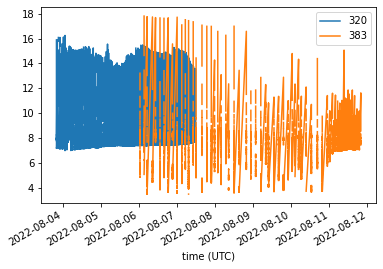

In [19]:
df_shallow["temperature (Celsius)"].plot(label="320")
df_deep["temperature (Celsius)"].plot(label="383")

plt.legend();

In [20]:
df_shallow1 = df_shallow.resample('1D').mean()
df_deep1 = df_deep.resample('1D').mean()

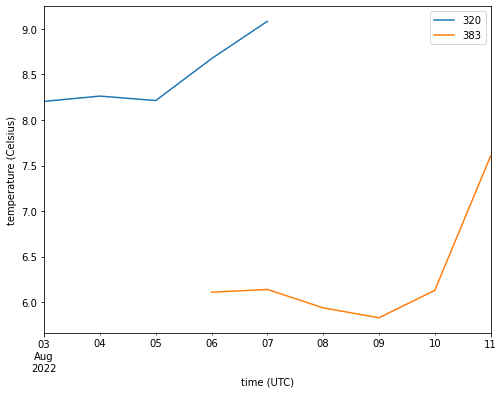

In [21]:
fig, (ax1) = plt.subplots(1,1, sharex=True, figsize=(8,6))
df_shallow1['temperature (Celsius)'].plot(ax=ax1,label="320")
df_deep1['temperature (Celsius)'].plot(ax=ax1,label="383")
ax1.set_ylabel('temperature (Celsius)')
ax1.legend()


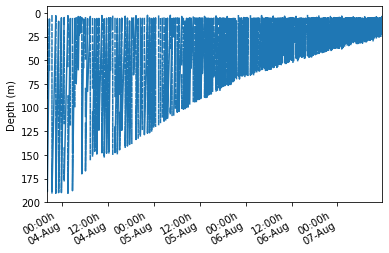

In [22]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()

ax.plot(df_shallow.index, df_shallow["depth (m)"]);
ax.set_ylabel("Depth (m)");
ax.invert_yaxis()
ax.set_xlim(df_shallow.index[0], df_shallow.index[-1])
xfmt = mdates.DateFormatter("%H:%Mh\n%d-%b")
ax.xaxis.set_major_formatter(xfmt)
fig.autofmt_xdate()

In [23]:
def uniq(da):
'''Find unique longitudes, and treat them as stations.
Also return the depth range over which to interpolate.
'''
lon = np.unique(da.longitude.values)
stn = np.array(range(lon.shape[0]))
depth_int = np.array(range(0, int(np.max(da.depth).values+1), 3))
return lon, stn, depth_int
def interp(da, station, lon, stn, depth_int):
'''Given a dataset and station number, return interpolated variables.
da: dataset
station: a certain station
lon, stn: uniques longitudes and station numbers
depth_int: the depth range over which to interpolate
'''
# unique longitudes and stations
lon, stn, depth_int = uniq(da)


IndentationError: expected an indented block after function definition on line 1 (1715769625.py, line 2)

In [24]:
# First, we define a function that moves (displaces) a lat / lon point a given distance away.
def displace(
    lat: float = 0,
    lon: float = 0,
    delta_n: float = 0,
    delta_e: float = 1000,
) -> (float, float):
    '''
    displace: given a lat lon pair, return the lat lon pair after displacement
    
    Parameters:
    lat: int or float - origin latitude in signed degrees default 0
    lon: int or float - origin longitude in signed degrees default 0
    delta_n: int or float - displacement in y direction metres default 0
    delta_e: inr or float - displacement in x direction metres default 1000
    
    returns
    (float, float) - lat, lon of displaced point signed degrees
    
    Side effects:
    None
    
    Limitations:
    This is for creating scale bars (and the like), and is NOT for navigation usage
    It assumes the earth is a perfect sphere.
    '''

    # Earth’s radius, sphere
    R = 6378137.0

    # offsets in meters
    dn = delta_n
    de = delta_e

    Pi = math.pi

    # Coordinate offsets in radians
    dLat = dn / R
    dLon = de / (R * math.cos(Pi * lat / 180))

    # OffsetPosition, decimal degrees
    lat2 = lat + dLat * 180 / Pi
    lon2 = lon + dLon * 180 / Pi

    return (lat2, lon2)


# end displace

In [25]:
    def blank_axes(ax):
        """
        blank_axes:  blank the extraneous spines and tick marks for an axes

        Input:
        ax:  a matplotlib Axes object

        Output: None
        """


        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('none')
        ax.xaxis.set_ticks_position('none')
        ax.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False ,\
                        bottom=False, top=False, left=False, right=False)
    #end blank_axes

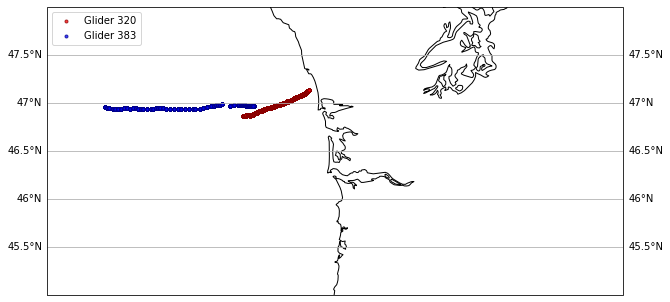

In [28]:
fig = plt.figure(figsize=(10,12))

left = 0.2
bottom = 0
width = 0.8
height = 0.90
rect = [left,bottom,width,height]

ax = plt.axes(rect, projection=ccrs.PlateCarree(), )
ax.set_extent((-127, -121, 45, 48))

ax.coastlines(resolution='10m', zorder=2)


ax.gridlines(draw_labels=True, xlocs=[150, 152, 154, 155])
ax.scatter(df_shallow['longitude (degrees_east)'],df_shallow['latitude (degrees_north)'], c='r', s=9, label ="Glider 320",
        edgecolor='darkred',alpha=0.75,
        transform=ccrs.PlateCarree());

ax.scatter(df_deep['longitude (degrees_east)'],df_deep['latitude (degrees_north)'], c='b', s=9, label ="Glider 383",
        edgecolor='darkblue',alpha=0.75,
        transform=ccrs.PlateCarree());
ax.legend(loc="upper left")
lon0, lon1, lat0, lat1 = ax.get_extent()

plt.show()